In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import random,math
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os,torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [79]:
def evaluation(model_arch,dataloader_test, bs):
    rmse = []
    maes = []
    ts = ToTensor()
    for i_test,sample_test in enumerate(dataloader_test):
        sample_test = ts(bs,sample_test)
        preds = model_arch(sample_test['inputs'])
        targets = sample_test['outputs']
        error = ((preds-targets)**2).sum(1).mean().detach().numpy()
        mae = (preds-targets).abs().sum(1).mean().detach().numpy()
        rmse.append(math.sqrt(error))
        maes.append(mae)
    return {'rmse':np.mean(rmse),'mae':np.mean(maes)}

In [42]:
class TrafficForecast(nn.Module):

    def __init__(self,input_dim,horizon):
        super(TrafficForecast, self).__init__()

        self.linear1 = nn.Linear(input_dim, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, horizon)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        return x

In [68]:
def get_zscore(x, mu,std):
     return (x - mu)/std

class TrafficDataset(Dataset):
  def __init__(self,root_dir,csv_path,window, horizon):

    ## pass normalization as an input
    ## if user wants to transform pass normalization and to tensor.
    ## add day of week and hour.
    self.root_dir = Path(root_dir)
    self.csv_path = csv_path

    self.df = pd.read_csv(os.path.join(self.root_dir,self.csv_path))
    self.df = self.df[['detector_id', 'travelway','loc', 'datetime', 'speed', 'volume', 'occupancy', 'congested']]
    self.df['datetime'] = pd.to_datetime(self.df['datetime'])
    for norm_cols in [('volume','volume_normal'),('occupancy','occu_normal')]:
      self.mu = self.df[norm_cols[0]].mean()
      self.std = self.df[norm_cols[0]].std()
      self.df[norm_cols[1]] = self.df.apply(lambda x: get_zscore(x[norm_cols[0]], self.mu,self.std),axis=1)

    self.df = self.df.sort_values(by=['datetime'])

    uuids = self.df['detector_id'].unique()[0:5]
    # self.df = self.df[self.df['detector_id'].isin(uuids)]
    self.inputs = []
    self.outputs = []
    # window = 10
    # horizon = 3
    for uuid in uuids:
      df_cur = self.df[self.df['detector_id'] == uuid]
      input_output = list(df_cur['volume_normal'].values)
      for t in range(0,len(input_output)-(window + horizon)):
        self.inputs.append(input_output[t:t+window])
        self.outputs.append(input_output[t+window:t+window+horizon])

    # # input_output = list(self.df['volume_normal'].values)
    # window = 10
    # # for t in range(len(input_output)-window):
    # self.inputs = []
    # for t in range(0,len(input_output)-window,window):
    #   self.inputs.append(input_output[t:t+window])

    # self.inputs = self.inputs[0:-1]
    # self.outputs = self.inputs[1:]
    # # print (self.inputs)
    print (len(self.inputs),len(self.outputs))

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self,idx):
    X = torch.tensor(self.inputs[idx])
    y=torch.tensor(self.outputs[idx])

    return {'inputs':X,'outputs':y}

class ToTensor(object):
    def __call__(self, bs,sample):
        input, output = sample['inputs'], sample['outputs']

        return {'inputs': torch.tensor(np.array(input),dtype=torch.float32).reshape(bs,-1),
                'outputs': torch.tensor(np.array(output),dtype=torch.float32).reshape(bs,-1)}

In [69]:
window = 10; horizon = 10
traffic_obj_train = TrafficDataset('/content/drive/MyDrive/3semester/8160/hw4/data','train.csv',window, horizon)
traffic_obj_test = TrafficDataset('/content/drive/MyDrive/3semester/8160/hw4/data','test.csv',window, horizon)

41641 41641
22290 22290


In [ ]:
# traffic_obj.df.head()

In [ ]:
# traffic_obj_train.df.plot(x='datetime',y='volume_normal')

In [70]:
bs = 500
dataloader_train = DataLoader(traffic_obj_train, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)
dataloader_test = DataLoader(traffic_obj_test, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)

In [71]:
ts = ToTensor()
for i, sample in enumerate(dataloader_train):
  # print (sample)
  print (sample['inputs'].size(),sample['outputs'].size())
  sample = ts(bs,sample)
  print (sample['inputs'].size(),sample['outputs'].size())
  if i == 1:
    break

torch.Size([500, 10]) torch.Size([500, 10])
torch.Size([500, 10]) torch.Size([500, 10])
torch.Size([500, 10]) torch.Size([500, 10])
torch.Size([500, 10]) torch.Size([500, 10])


In [72]:
input_dim = traffic_obj_train[0]['inputs'].shape[0]
horizon = traffic_obj_train[0]['outputs'].shape[0]
model = TrafficForecast(input_dim,horizon)
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [73]:
print (model)

TrafficForecast(
  (linear1): Linear(in_features=10, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
  (activation): ReLU()
)


In [74]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 50
ts = ToTensor()
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    sample_batched = ts(bs,sample_batched)
    outputs = model(sample_batched['inputs'])
    loss = criterion(outputs, sample_batched['outputs'])
    # print (loss)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

  for i_test,sample_test in enumerate(dataloader_test):
      sample_test = ts(bs,sample_batched)
      outputs = model(sample_test['inputs'])
      test_loss = criterion(outputs, sample_test['outputs'])
      test_losses.append(test_loss.item())

  mean_loss.append(np.mean(losses))
  mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 10 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}, Testing Loss: {np.mean(test_losses):.4f}')

 20%|██        | 10/50 [00:27<01:49,  2.75s/it]

Epoch 10/50, Training Loss: 0.2556, Testing Loss: 0.0939


 40%|████      | 20/50 [00:53<01:17,  2.58s/it]

Epoch 20/50, Training Loss: 0.2423, Testing Loss: 0.0929


 60%|██████    | 30/50 [01:21<00:52,  2.62s/it]

Epoch 30/50, Training Loss: 0.2349, Testing Loss: 0.0924


 80%|████████  | 40/50 [01:49<00:25,  2.60s/it]

Epoch 40/50, Training Loss: 0.2295, Testing Loss: 0.0920


100%|██████████| 50/50 [02:17<00:00,  2.74s/it]

Epoch 50/50, Training Loss: 0.2250, Testing Loss: 0.0918


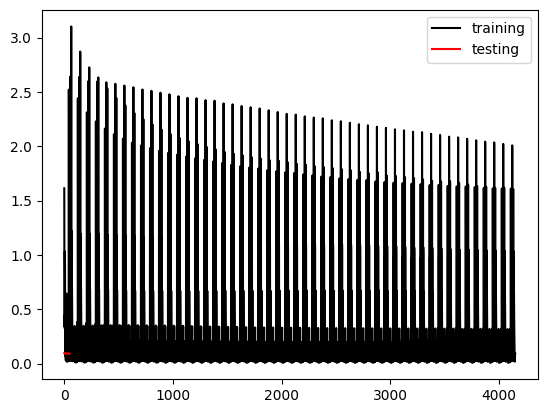

In [75]:
plt.plot(losses,'k',label='training')
plt.plot(mean_test_loss,'r',label='testing')
plt.legend()

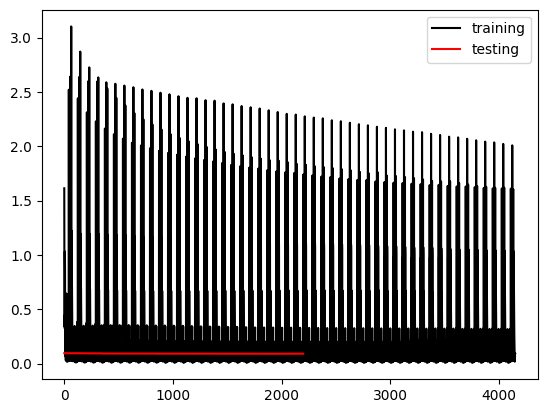

In [76]:
plt.plot(losses,'k',label='training')
plt.plot(test_losses,'r',label='testing')
plt.legend()

In [77]:
torch.save(model.state_dict(), 'armodel.pt')

In [80]:
model_arch = TrafficForecast(input_dim,horizon)
model_arch.load_state_dict(torch.load('armodel.pt'))
model_arch.eval()

TrafficForecast(
  (linear1): Linear(in_features=10, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
  (activation): ReLU()
)

In [81]:
results = evaluation(model_arch,dataloader_test,bs)
print (results)

{'rmse': 1.5058965690655897, 'mae': 3.7029676}


In [82]:
pred_plot = []
for i_test,sample_test in enumerate(dataloader_test):
    sample_test = ts(bs,sample_batched)
    preds = model_arch(sample_test['inputs'])
    targets = sample_test['outputs']

In [83]:
pred_out = [x.detach().numpy() for sublist in preds for x in sublist]
target_out = [x.detach().numpy() for sublist in targets for x in sublist]

(-1.5, 5.0)

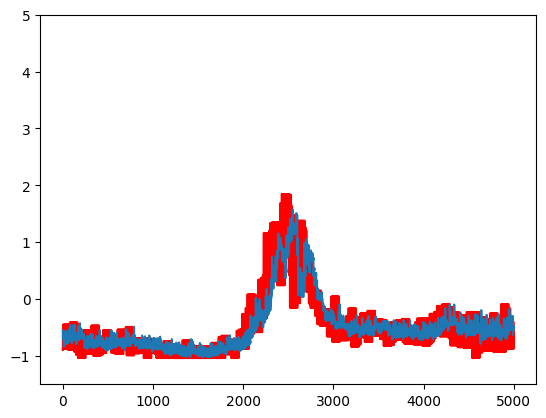

In [84]:
plt.plot(target_out,'r')
plt.plot(pred_out)
plt.ylim([-1.5,5])

(array([  18.,   17.,   50.,  267., 1857., 2262.,  340.,  115.,   60.,
          14.]),
 array([-1.62115598, -1.30109012, -0.98102438, -0.66095853, -0.34089273,
        -0.02082694,  0.29923886,  0.61930466,  0.93937051,  1.25943625,
         1.57950211]),
 <BarContainer object of 10 artists>)

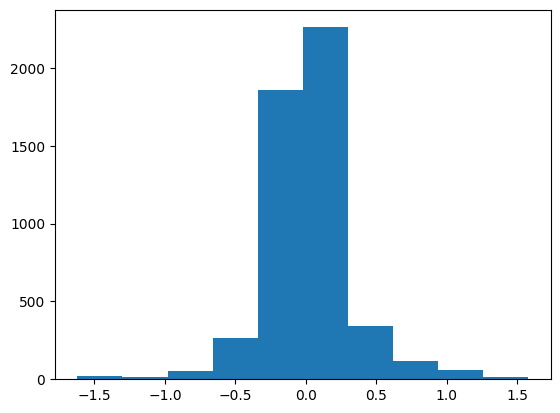

In [85]:
plt.hist((np.array(target_out)-np.array(pred_out)))

In [ ]:
## in-class assignment
## evaluate the influence of window and horizon
#increase horizon 5 10 20
## compare accuracy when uuids = 5, 10, 15 detetors